In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('data/final_data.csv', sep=",", header = 0)

In [4]:
data_columns = [
    "Bid ID", "Timestamp", "Log type", "iPinYou ID", "User-Agent", "IP",
    "Region", "City", "Ad exchange", "Domain", "URL", "Anonymous URL ID",
    "Ad slot ID", "Ad slot width", "Ad slot height", "Ad slot visibility",
    "Ad slot format", "Ad slot floor price", "Creative ID", "Bidding price",
    "Paying price", "Key page URL", "Advertiser ID", "User Tags", 'All paying price',
]
columns_to_drop = [
    "Bid ID", "iPinYou ID", "User-Agent", "IP", "URL", "Log type", "Timestamp",
    "Anonymous URL ID", "Creative ID", "Key page URL", "Ad slot ID", "Advertiser ID", 'All paying price', "User Tags",
]


In [5]:
#data = data.drop_duplicates()
data = data[data['Advertiser ID'] == 3358]
data = data[data["Paying price"] > 0]

In [6]:
def parse_timestamp(ts):
    ts_str = str(ts)
    year = int(ts_str[:4])
    month = int(ts_str[4:6])
    day = int(ts_str[6:8])
    hour = int(ts_str[8:10])
    minute = int(ts_str[10:12])
    return pd.Timestamp(year=year, month=month, day=day, hour=hour, minute=minute)


In [7]:
data['Timestamp'] = data['Timestamp'].apply(parse_timestamp)
data['Hour'] = data['Timestamp'].dt.hour
data['Weekday'] = data['Timestamp'].dt.weekday

In [8]:
data["s"] = data['Ad slot width'] * data['Ad slot height']
data['weekend_flag'] = data['Weekday'].isin([5, 6]).astype(int)
data['aspect_ratio'] = data['Ad slot width'] / (data['Ad slot height'] + 1e-6)
data['domain_hour_interaction'] = data['Domain'].astype(str) + '_' + data['Hour'].astype(str)
data['floor_bid_ratio'] = data['Bidding price'] / (data['Ad slot floor price'] + 1e-6)
categorical_features = [
    'City', 'Region', 'Ad exchange', 'Ad slot visibility', 'Ad slot format', "Hour", "Weekday", "Domain", "os", "device", "device_type", "browser"]

categorical_features+=[ 'weekend_flag', 'floor_bid_ratio', 'domain_hour_interaction']

In [10]:
data = data.drop(columns=columns_to_drop, errors='ignore')

In [11]:
for col in categorical_features:
    data[col] = data[col].fillna("missing").astype(str)

n_bins = 25
bins = np.linspace(data['Paying price'].min(), data['Paying price'].max(), n_bins + 1)
data['price_bin'] = pd.cut(data['Paying price'], bins=bins, labels=False, include_lowest=True)

X = data.drop(columns=['Paying price', 'price_bin'], errors='ignore')
y = data['price_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
missing_cols = set(categorical_features) - set(X_train.columns)
if missing_cols:
    raise ValueError(f"Следующие категориальные признаки отсутствуют в данных: {missing_cols}")

In [13]:
model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    task_type='GPU',
    od_wait=100
)
model.fit(X_train, y_train, eval_set = (X_test, y_test), cat_features=categorical_features, verbose = 100, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8013397	test: 2.8032240	best: 2.8032240 (0)	total: 326ms	remaining: 2m 42s
100:	learn: 1.8738206	test: 1.8725249	best: 1.8725249 (100)	total: 43.7s	remaining: 2m 52s
200:	learn: 1.7813545	test: 1.7821020	best: 1.7821020 (200)	total: 1m 26s	remaining: 2m 8s
300:	learn: 1.7306986	test: 1.7344506	best: 1.7344506 (300)	total: 2m 11s	remaining: 1m 27s
400:	learn: 1.7030266	test: 1.7092203	best: 1.7092203 (400)	total: 2m 56s	remaining: 43.6s
499:	learn: 1.6864172	test: 1.6945938	best: 1.6945938 (499)	total: 3m 40s	remaining: 0us
bestTest = 1.694593789
bestIteration = 499


In [ ]:
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, probs_class, class_index, n_bins=10):

    actual_class = (y_true == class_index).astype(int)
    
    bins = np.linspace(0, 1, n_bins + 1)
    
    bin_ids = np.digitize(probs_class, bins) - 1 
    
    bin_centers = []
    bin_true_fracs = []
    
    for b in range(n_bins):
        idx = (bin_ids == b)
        if np.any(idx): 
            avg_prob = np.mean(probs_class[idx])
            true_frac = np.mean(actual_class[idx])
            bin_centers.append(avg_prob)
            bin_true_fracs.append(true_frac)
        else:
            bin_centers.append(np.nan)
            bin_true_fracs.append(np.nan)
    

    plt.plot(bin_centers, bin_true_fracs, "o-", label=f"Class {class_index}")
    plt.plot([0, 1], [0, 1], "k--", label="Идеальная калибровка")
    plt.title("Reliability Diagram (One-vs-All)")
    plt.xlabel("Средняя предсказанная вероятность")
    plt.ylabel("Доля истинных положительных")
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

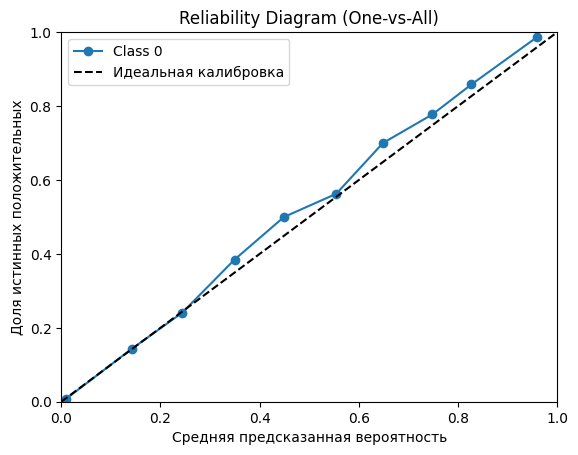

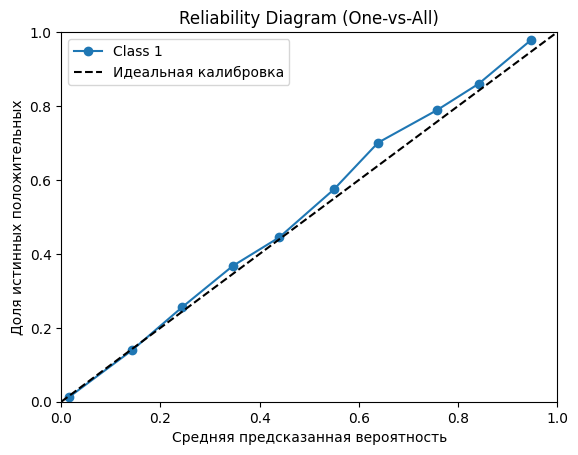

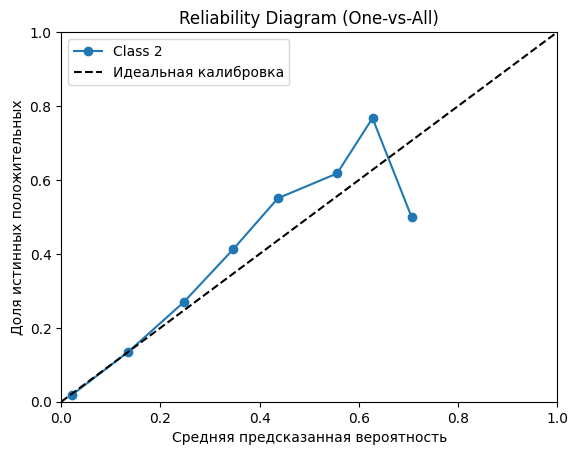

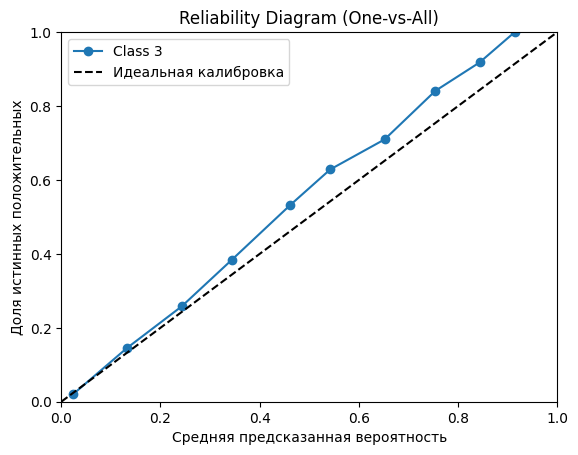

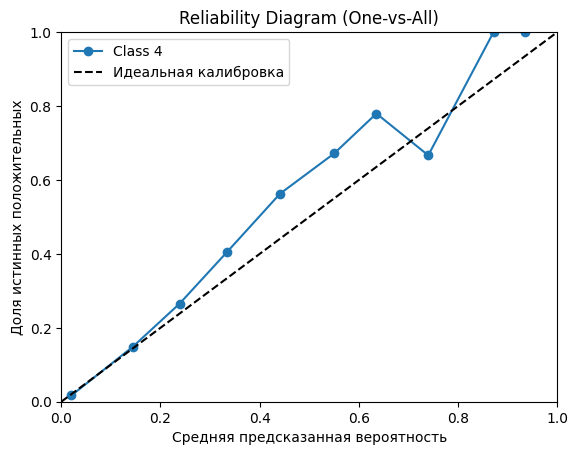

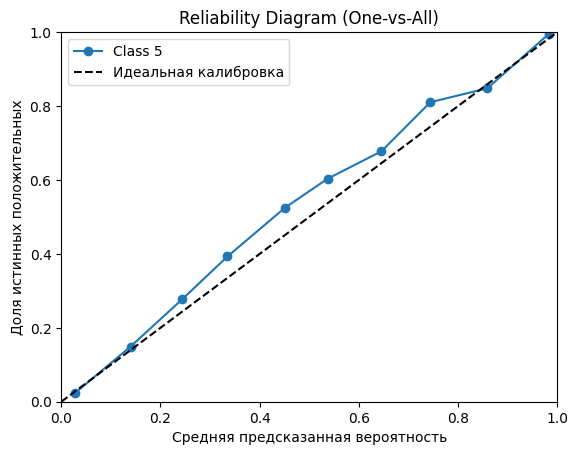

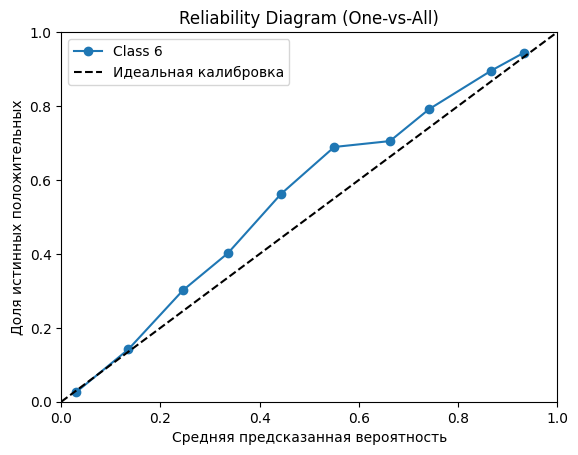

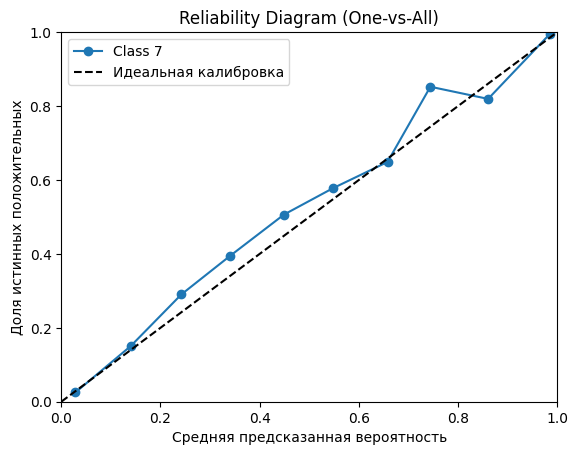

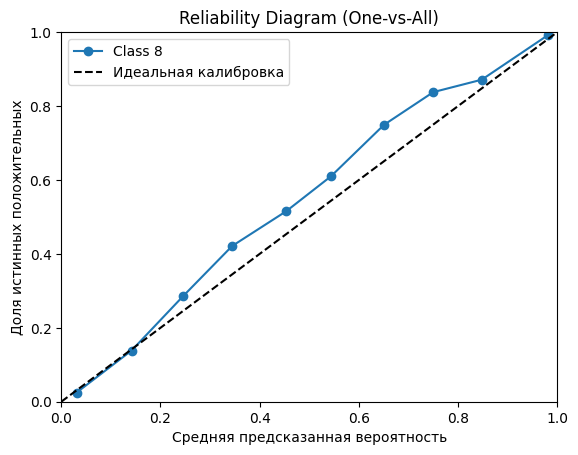

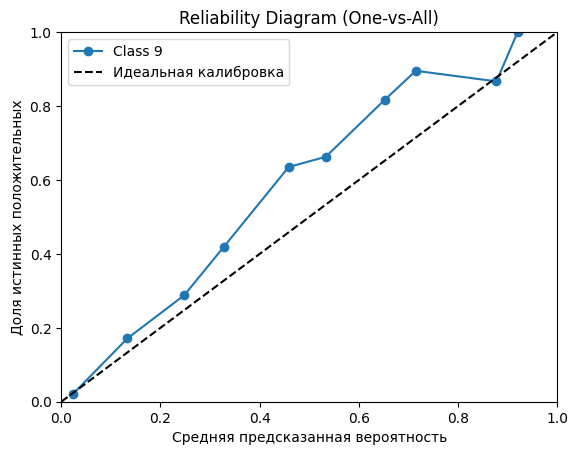

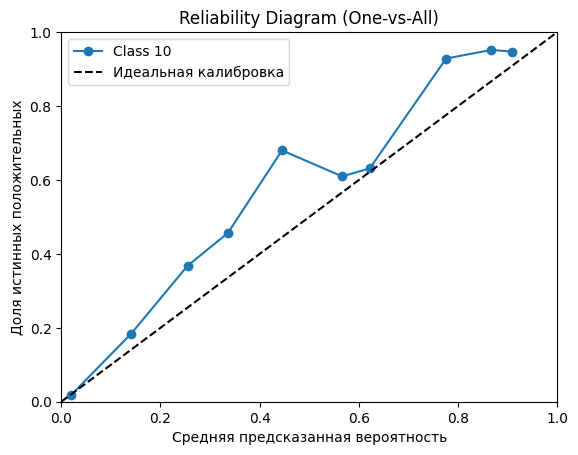

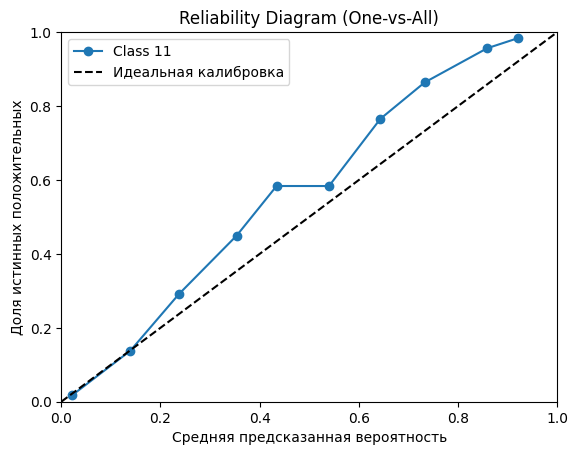

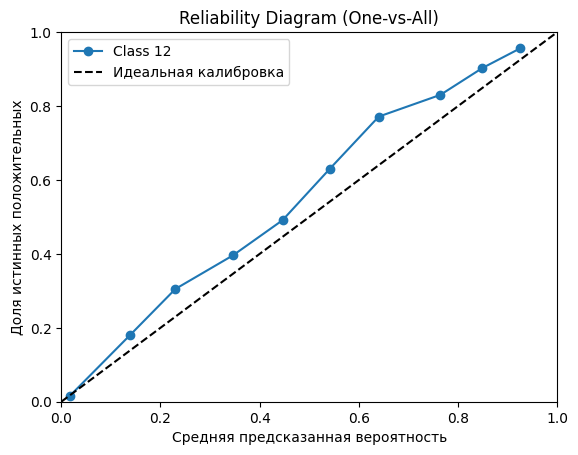

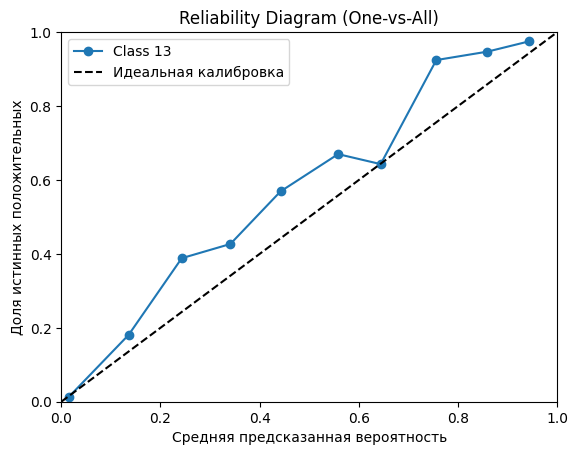

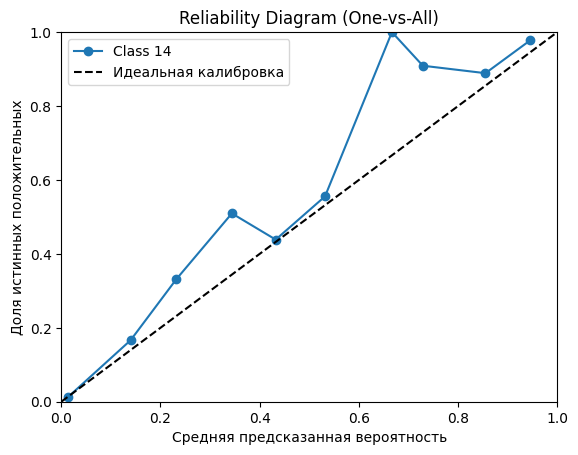

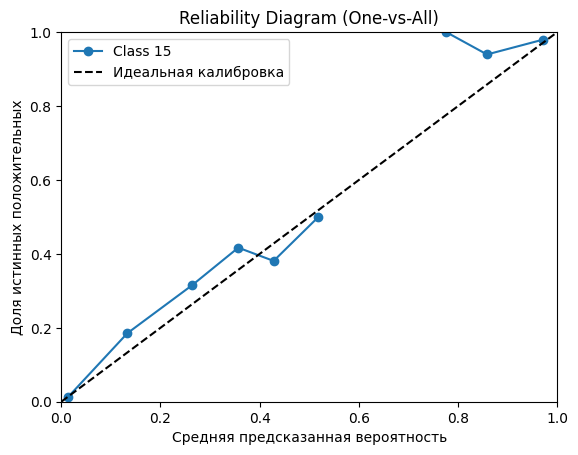

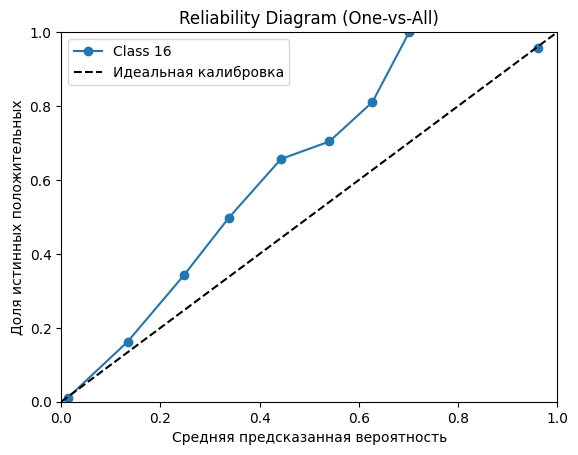

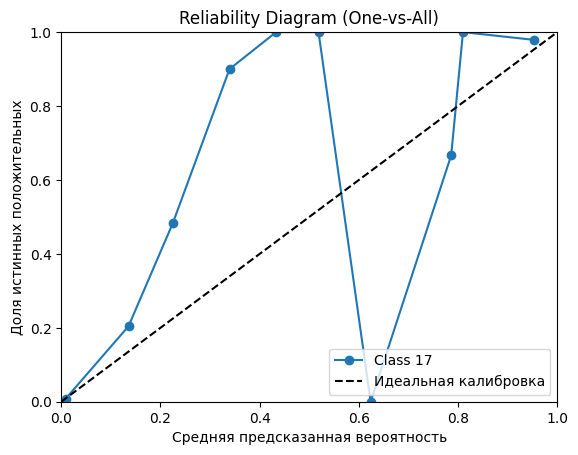

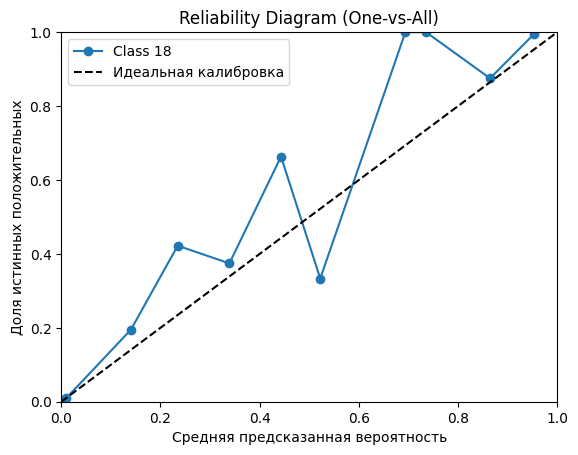

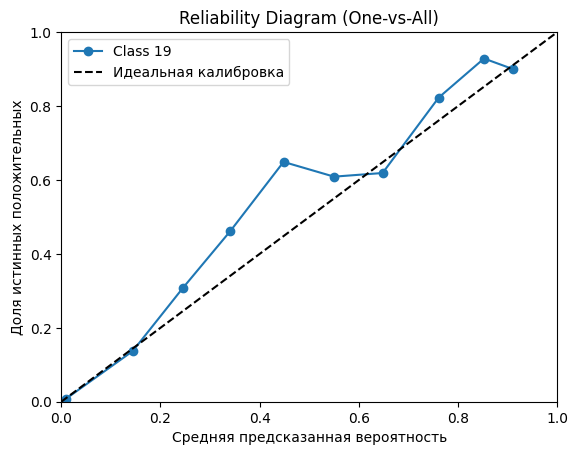

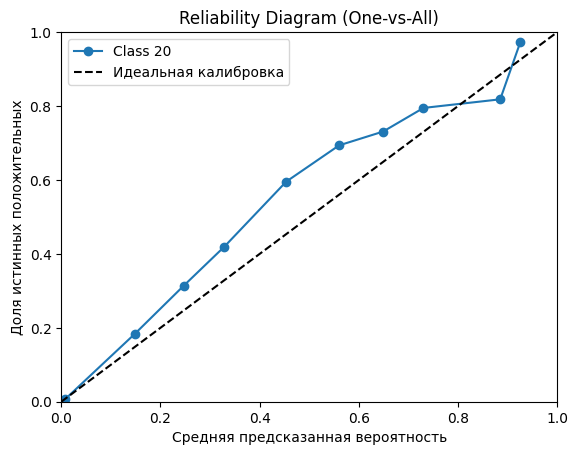

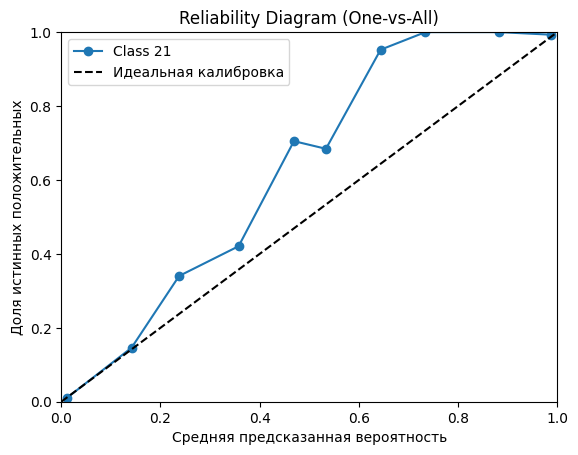

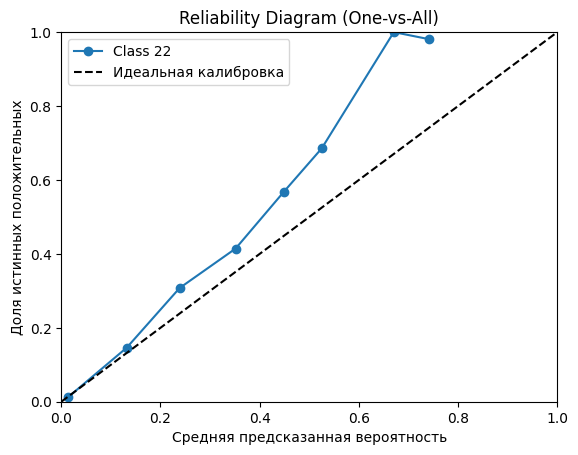

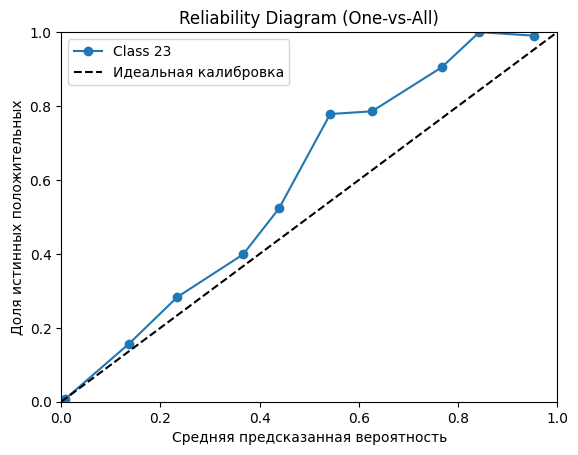

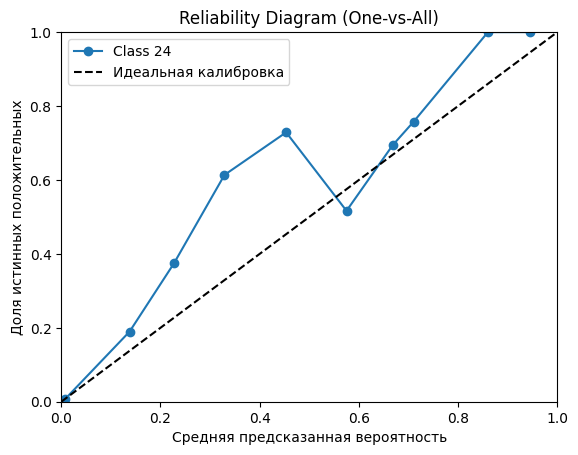

In [18]:
probs = model.predict_proba(X_test)
num_classes = probs.shape[1]  # совпадает с n_bins
for class_idx in range(num_classes):
    plot_calibration_curve(y_test, probs[:, class_idx], class_idx, n_bins=10)

In [ ]:
from scipy.stats import entropy
num_classes = probs.shape[1]

true_counts = np.bincount(y_test, minlength=num_classes)
P = true_counts / true_counts.sum()

Q = probs.mean(axis=0)


kl_divergence = entropy(P, Q)  
print("KL divergence: ", kl_divergence)

KL divergence:  3.766974503240897e-05


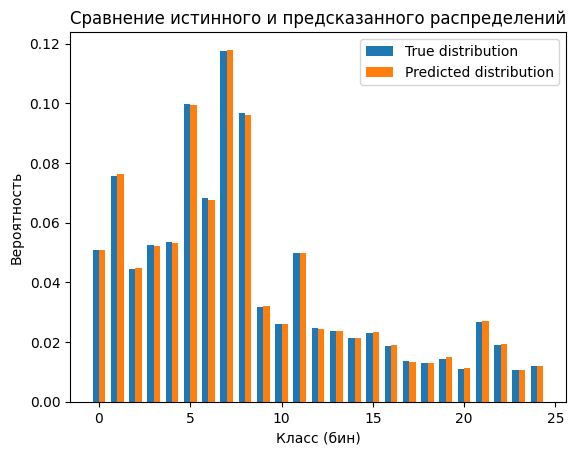

In [21]:
import matplotlib.pyplot as plt

classes = np.arange(num_classes)
width = 0.35

plt.bar(classes - width/2, P, width=width, label='True distribution')
plt.bar(classes + width/2, Q, width=width, label='Predicted distribution')
plt.xlabel('Класс (бин)')
plt.ylabel('Вероятность')
plt.title('Сравнение истинного и предсказанного распределений')
plt.legend()
plt.show()